# COMP7015: Artificial Intelligence *(Semester 1, 2024/25)*

# Programming Assignment 2

**Instructions:**
1. Fill in your name and student id in the following cell.
2. Write all you codes in this jupyter notebook.
3. You can define your own functions, methods, classes, and variables as you need.
4. Please name your functions and variables in a clear and concise way to maximize the redability of your codes.
5. Name your jupyter notebook in the format of `pa2_<student id>.ipynb` and submit it in Moodle. For example, `pa2_16483715.ipynb`.
6. What you write in this notebook must be your own input. Copying from others and online resources are subject to heavy penalty. Lending and borrowing assignment solutions are both regarded as dishonest behaviours and are subject to heavy penalty and disciplinary actions.
7. You can use Google Colab to do the assignment. After finishing the assignment, download it from Colab and submit the `.ipynb` file containing all outputs to Moodle.

In [1]:
# Fill in your name and student ID
name = 'KWAN CHO FAI'
student_id = '23470941'

# Q1. Handwritten letter recognition with MLP (50 marks)

In this task, you are required to define and train an MLP model for the handwritten letter recognition task. We use the `EMNIST` dataset. See [[its Readme file]](https://www.westernsydney.edu.au/__data/assets/text_file/0019/1204408/EMNIST_Readme.txt) for a detailed description. We provide you with the following code block to load the dataset.

In this dataset, there are 124,800 images for training and 20,800 images for testing. Each image corresponds to one of the 26 English letters.

In [1]:
import torch

import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

from matplotlib import pyplot as plt

In [2]:
# Some transformation are needed.
emnist_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),  # rotates the image by 90 degree
    lambda img: transforms.functional.hflip(img),  # flip the image horizontally
    transforms.ToTensor()
])

# The dataset can be loaded using the Pytorch function as below
emnist_train = EMNIST('./', train=True, download=True, split='letters',
                      transform=emnist_transform,
                      target_transform=lambda x: x-1)
emnist_test = EMNIST('./', train=False, download=True, split='letters',
                     transform=emnist_transform,
                     target_transform=lambda x: x-1)

A visualization of the dataset can be done as follows. It gives you an intuition about the dataset we are working with.

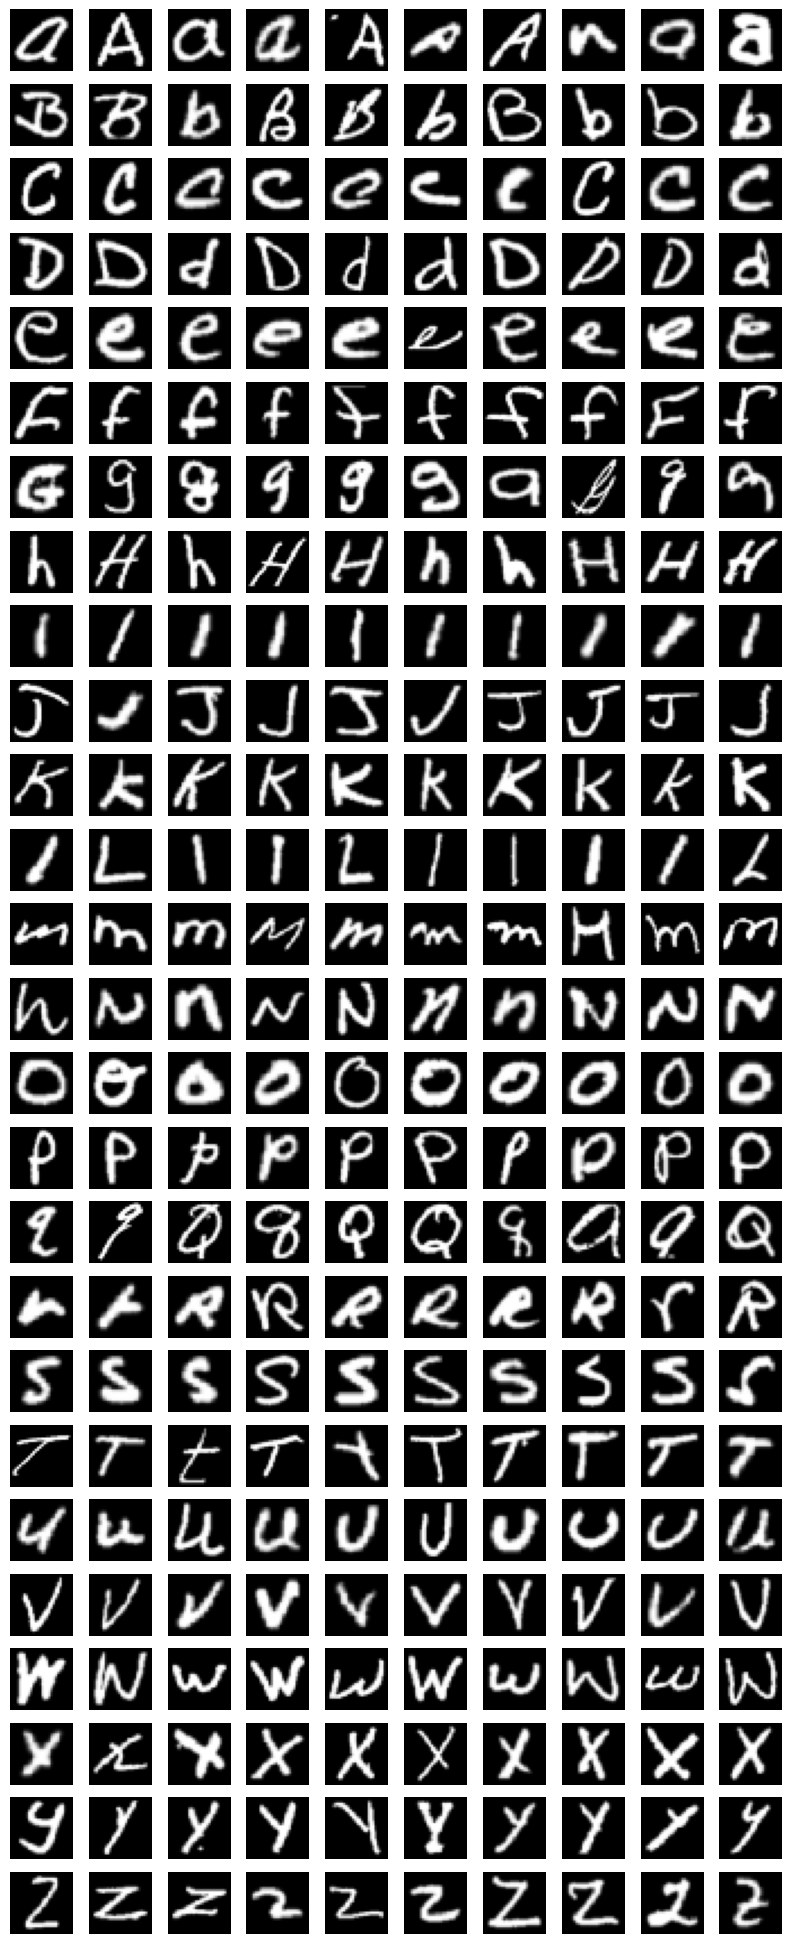

In [4]:
_, labels = zip(*emnist_train)
indices = [[i for i in range(len(labels)) if labels[i]==c] for c in range(26)]

fig, ax = plt.subplots(26, 10, figsize=(10, 25))
for c in range(26):
    for i in range(10):
        ax[c][i].imshow(emnist_train[indices[c][i]][0][0].numpy(), cmap='gray')
        ax[c][i].axis('off')
plt.show()

## (a) Define an MLP model to recognize the handwritten letters. Use three hidden layers for this MLP and the hidden sizes of the three hidden layers are 256, 512, and 512, respectively. Use ReLU as the activation function. (15 marks)

In [4]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        
        self.linear1 = torch.nn.Linear(input_dim, 256)        
        self.linear2 = torch.nn.Linear(256, 512)
        self.linear3 = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, output_dim)
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.linear1(x)
        x = F.relu(x)  

        x = self.linear2(x)
        x = F.relu(x)  
        
        x = self.linear3(x)
        x = F.relu(x)  
        
        return self.output(x)

## (b) Train an MLP model to recognize the handwritten letters. The following aspects should be covered in your answers.
1. The full pipeline of training such a model. (15 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (10 marks)
2. Compute the accuracy for the test set. (10 marks)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import numpy as np
from copy import deepcopy 

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(emnist_train))  # 80% for training
val_size = len(emnist_train) - train_size  # 20% for validation

trainData, valData = random_split(emnist_train, [train_size, val_size])

# Define data loaders
batch_size = 64
train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valData, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=False)

input_dim = 28*28  #EMNIST image size
output_dim = 26    #letter A-Z


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)
mlp = MLP(input_dim, output_dim).to(device)
criterion  = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0008, weight_decay=0.00055) # Adam optimizer



num_epochs = 50
best_val_acc = 0
early_stopping_counter = 0
early_stopping_patience = 5

for epoch in range(num_epochs):
    train_loss = 0.00
    val_loss = 0.00
    train_acc=0.00
    val_acc  = 0
    
    train_correct = 0 # for calculate the train accuracy in train set
    train_total = 0 # for calculate the train accuracy in train set
    val_correct = 0 # for calculate the train accuracy in validation set
    val_total = 0 # for calculate the train accuracy in validation set
    
    mlp.train()  #training mode
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        mlp_pred = mlp(images)
        loss = criterion(mlp_pred, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


        _, predicted = torch.max(mlp_pred, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    train_acc = train_correct/train_total

    
    # valadtaion acc
    mlp.eval()  #eval mode
    with torch.no_grad():
        for images, labels in val_loader: #evaluate the result with validation data
            images, labels = images.to(device), labels.to(device)
            
            mlp_pred = mlp(images)
            loss = criterion(mlp_pred, labels)
            val_loss += loss.item()
            _, predicted = torch.max(mlp_pred, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
        val_acc = val_correct/val_total
        


    print(
    f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f},"
    f"Train accuracy: {train_acc:.4f},Validation accuracy: {val_acc:.4f}"
    )

    # Early stopping 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        best_model_wts = deepcopy(mlp.state_dict())  # Save the best model weights
        print(f"The best validation accuracy so far is: {best_val_acc:.4f}")
        print('The best model weights have been saved.')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience: #
            print(f"The training has been early stopped since there is no improvement on validation accuracy for more than {early_stopping_patience} epochs.")
            break

#finally compute Accuracy on Test Set 
test_correct = 0 
test_total = 0 
test_acc = 0.00

mlp.load_state_dict(best_model_wts)
print('Loaded the best model weights for evaluation.')
mlp.eval()  #eval mode
with torch.no_grad(): #calculating training accuracy
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        mlp_pred = mlp(images)
        _, predicted = torch.max(mlp_pred, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
test_acc = test_correct/test_total    

print(
    f"The accuracy on the test data set is: {test_acc:.4f}"
    )

Running on cuda
Epoch 1/50, Train Loss: 0.7009, Validation Loss: 0.4283,Train accuracy: 0.7826,Validation accuracy: 0.8615
The best validation accuracy so far is: 0.8615
The best model weights have been saved.
Epoch 2/50, Train Loss: 0.3672, Validation Loss: 0.3810,Train accuracy: 0.8808,Validation accuracy: 0.8796
The best validation accuracy so far is: 0.8796
The best model weights have been saved.
Epoch 3/50, Train Loss: 0.3146, Validation Loss: 0.3171,Train accuracy: 0.8961,Validation accuracy: 0.8972
The best validation accuracy so far is: 0.8972
The best model weights have been saved.
Epoch 4/50, Train Loss: 0.2847, Validation Loss: 0.3253,Train accuracy: 0.9051,Validation accuracy: 0.8950
Epoch 5/50, Train Loss: 0.2690, Validation Loss: 0.3266,Train accuracy: 0.9103,Validation accuracy: 0.8940
Epoch 6/50, Train Loss: 0.2565, Validation Loss: 0.3155,Train accuracy: 0.9140,Validation accuracy: 0.8973
The best validation accuracy so far is: 0.8973
The best model weights have been s

# Q2. Basics of Convolutional Neural Network (30 marks)

## (a) Complete the function below to compute the convolution given an `input_tensor` (a two-dimensional tensor), a `kernel_tensor` and a `stride_size`. For simplicity, we only consider gray scale images. The function should return the output after doing convolution. The followings are expected. (20 marks)
1. The function correctly computes the convolution. (10 marks)
2. The function correctly handles different stride sizes. (5 marks)
3. The function output has the the same size as the input by using padding. (5 marks) 

**Hint**: the padding size can be computed using the equation given in lectures that computes the output size of the convolution.

In [5]:
def convolution(input_tensor, kernel_tensor, stride_size):
    # fill in your codes
    input_size_n = input_tensor.shape[0]
    input_size_w = input_tensor.shape[1]

    kernel_size_n = kernel_tensor.shape[0]
    kernel_size_w = kernel_tensor.shape[1]

   #calculate the padding size to keep the same size as the input by using padding.
    cal_padding_n = ((input_size_n-1)*stride_size-input_size_n+kernel_size_n)/2
    cal_padding_w = ((input_size_w-1)*stride_size-input_size_w+kernel_size_w)/2
    remainder_n = ((input_size_n-1)*stride_size-input_size_n+kernel_size_n)%2
    remainder_w = ((input_size_w-1)*stride_size-input_size_w+kernel_size_w)%2
    
    if remainder_n == 0:
        padding_n_1 = int(cal_padding_n)
        padding_n_2 = int(cal_padding_n)
    else:
        padding_n_1 = int(cal_padding_n)+1
        padding_n_2 = int(cal_padding_n)

    if remainder_w==0:
        padding_w_1 = int(cal_padding_w)
        padding_w_2 = int(cal_padding_w)
    else:
        padding_w_1 = int(cal_padding_w)+1
        padding_w_2 = int(cal_padding_w)

    input_padded = torch.nn.functional.pad(input_tensor,(padding_n_1, padding_n_2, padding_w_1, padding_w_2), mode='constant', value=0)
    output = torch.zeros((input_size_n, input_size_w)) #same size as the input
    for i in range(0, output.shape[0]):
        for j in range(0, output.shape[1]):
            convolution = input_padded[
                                        i * stride_size : i * stride_size + kernel_size_n, 
                                        j * stride_size : j * stride_size + kernel_size_w
                                        ]
            output[i, j] = torch.sum(convolution * kernel_tensor)  
            
    return output

C:\Users\kwancfb\AppData\Local\Temp\ipykernel_32144\735132794.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load('./img.pt')


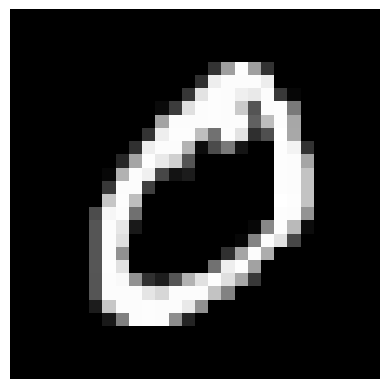

In [6]:
# load in an image
img = torch.load('./img.pt')
plt.imshow(img.numpy(), cmap='gray')
plt.axis('off')

# define a kernel
kernel = torch.FloatTensor([
    [-1, -1, -1],
    [1, 1, 1],
    [0, 0, 0]
])

##### The following code blocks are examples of calling this function. Do NOT modify them.

(-0.5, 27.5, 27.5, -0.5)

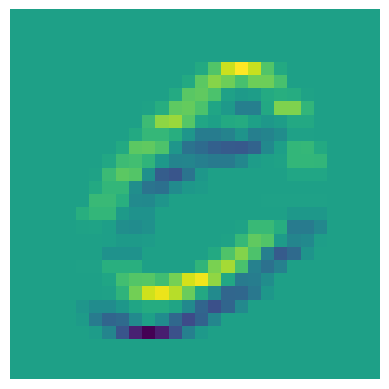

In [8]:
# An example of calling your function
output = convolution(img, kernel, stride_size=1)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

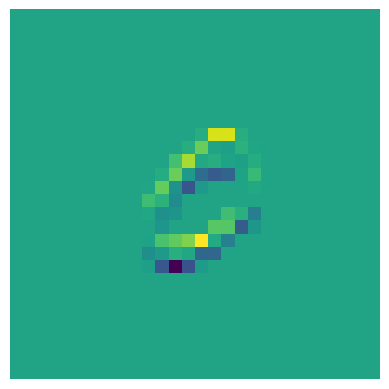

In [9]:
# Another example
output = convolution(img, kernel, stride_size=2)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

## (b) Complete the function below to do the max pooling given `input tensor` (a two-dimensional tensor), a `kernel_size` and a `stride_size`.  (10 marks)

In [10]:
def max_pooling(input_tensor, kernel_size, stride_size):
    # fill in your codes
    input_size_n = input_tensor.shape[0]
    input_size_w = input_tensor.shape[1]

    output_size_n = int(   (((input_size_n-kernel_size)/stride_size)+1)   )
    output_size_w = int(   (((input_size_w-kernel_size)/stride_size)+1)   )
    
    output = torch.zeros((output_size_n, output_size_w)) 
    for i in range(0, output.shape[0]):
        for j in range(0, output.shape[1]):
            maxpooling = input_tensor[
                                        i * stride_size : i * stride_size + kernel_size, 
                                        j * stride_size : j * stride_size + kernel_size
                                        ]
            output[i, j] = torch.max(maxpooling)

    return output

##### The following code block is an example of calling this function. Do NOT modify it.

(-0.5, 13.5, 13.5, -0.5)

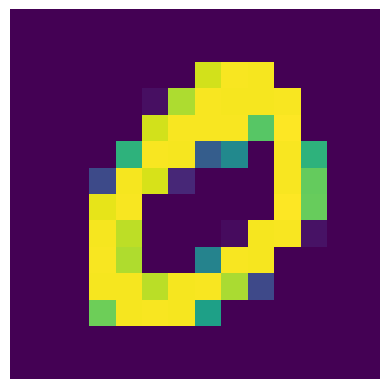

In [11]:
output_pooling = max_pooling(img, kernel_size=2, stride_size=2)

plt.imshow(output_pooling.numpy())
plt.axis('off')

# Q3. Using Pretrained CV Models (20 marks)

In this question, we use a pretrained CV model and fine-tune it for a classification task. We use the ResNet model. Here is a detailed insruction about how to use it: https://pytorch.org/hub/pytorch_vision_resnet/.

The `torch.hub` module is a newer way to import and use pretrained models. The procedures of fine-tune it are the same as introduced in the lab session.

In [6]:
# The pretrained model can be loaded by the following line and the corresponding data transform is given.

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

resnet_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in C:\Users\belly/.cache\torch\hub\pytorch_vision_v0.10.0


In [13]:
# this shows you the architecture of the ResNet model.
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Hint**: As shown above, the last layer for classification in ResNet18 model is called `fc`.

## (a) Fine-tune the ResNet model for the handwritten letter recognition dataset (EMNIST) we used in Q1.  The followings are expected. (15 marks)

1. Build the full pipeline of fine-tuning the pretrained ResNet model. (5 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (5 marks)
2. Compute the accuracy for the test set. (5 marks)

In [24]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

#Freeze the gradients for fine tune
for param in model_ft.parameters():
    param.requires_grad = False

#Unfreezing the layer4 Block: to retrain the last 2 block for better fitting to the EMNIST dataset
for param in model_ft.layer4.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device in use:', str(device))
model_ft = model_ft.to(device)



Using cache found in C:\Users\belly/.cache\torch\hub\pytorch_vision_v0.10.0


Device in use: cuda:0


In [25]:
import torch.nn as nn

# We use the cross entropy as loss function
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()

model_ft.fc = nn.Linear(num_ftrs, 26)
params_to_update = []
print("Params to learn:")
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Create an Adam optimizer with the gathered parameters
#optimizer_ft = Adam(params_to_update, lr=0.0001)
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0003, weight_decay=0) # Adam optimizer

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [17]:
from torch.utils.data import DataLoader, random_split, TensorDataset
# Some transformation are needed.
emnist_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),  # rotates the image by 90 degree
    lambda img: transforms.functional.hflip(img),  # flip the image horizontally
    transforms.ToTensor()
])

# The dataset can be loaded using the Pytorch function as below
emnist_train2 = EMNIST('./', train=True, download=True, split='letters',
                      transform=resnet_transform,
                      target_transform=lambda x: x-1)
emnist_test2 = EMNIST('./', train=False, download=True, split='letters',
                     transform=resnet_transform,
                     target_transform=lambda x: x-1)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(emnist_train))  # 80% for training
val_size = len(emnist_train) - train_size  # 20% for validation


batch_size = 64
# Define data loaders
trainData, valData = random_split(emnist_train2, [train_size, val_size])
train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valData, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(emnist_test2, batch_size=batch_size, shuffle=False)

In [26]:
import time
from copy import deepcopy


num_epochs = 50
since = time.time()
early_stopping_counter = 0
early_stopping_patience = 5

# record the historical and the best accuracy.
val_acc_history = []
best_val_acc = 0.0
best_model_wts = deepcopy(model_ft.state_dict())

model_ft = model_ft.to(device)
print('Running on:', device)
for epoch in range(num_epochs):
    tic = time.time()
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 15)

    # phase one: training.
    model_ft.train() # set the model to training mode
    running_loss = 0
    running_corrects = 0

    # iterate over training subset
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
            
        # set the parameter gradients to zero
        optimizer_ft.zero_grad()
        # forward pass: get prediction and compute loss
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        # backward pass: compute gradients
        loss.backward()

        # update parameters
        optimizer_ft.step()

        # get the predicted class indices
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)


    
    # The training phase in this epoch is done. Compute the statistics.
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print('Training Loss: {:.4f}, training accucary: {:.4f}'.format(epoch_loss, epoch_acc))

    # phase two: validation.
    model_ft.eval()   # set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    
    # computing gradient is not necessary in the validation phase.
    with torch.no_grad():
        for inputs, labels in val_loader:            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get prediction and compute loss
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            # get the predicted class indices
            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # The evaluation phase in this epoch is done. Compute the statistics.
    validation_loss = running_loss / len(val_loader.dataset)
    val_acc  = running_corrects.double() / len(val_loader.dataset)
    print('Validation Loss: {:.4f} Validation Accuracy: {:.4f}'.format(validation_loss, val_acc))


    
    # check if the performance improves, copy the model if yes.
    # Early stopping 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        best_model_wts = deepcopy(model_ft.state_dict())  # Save the best model weights
        print(f"The best validation accuracy so far is: {best_val_acc:.4f}")
        print('The best model weights have been saved.')
        print('Time: {:.1f}s'.format(time.time()-tic))
        print('='*15)
        print()
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience: #
            print(f"The training has been early stopped since there is no improvement on validation accuracy for more than {early_stopping_patience} epochs.")
            print('Time: {:.1f}s'.format(time.time()-tic))
            print('='*15)
            print()
            break
            




time_elapsed = time.time() - since
print('Finetuning complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_val_acc))



Running on: cuda:0
Epoch 1/50
---------------
Training Loss: 0.2524, training accucary: 0.9198
Validation Loss: 0.1517 Validation Accuracy: 0.9480
The best validation accuracy so far is: 0.9480
The best model weights have been saved.
Time: 263.6s

Epoch 2/50
---------------
Training Loss: 0.1387, training accucary: 0.9504
Validation Loss: 0.1524 Validation Accuracy: 0.9468
Epoch 3/50
---------------
Training Loss: 0.1050, training accucary: 0.9603
Validation Loss: 0.1521 Validation Accuracy: 0.9483
The best validation accuracy so far is: 0.9483
The best model weights have been saved.
Time: 253.0s

Epoch 4/50
---------------
Training Loss: 0.0834, training accucary: 0.9669
Validation Loss: 0.1779 Validation Accuracy: 0.9438
Epoch 5/50
---------------
Training Loss: 0.0673, training accucary: 0.9727
Validation Loss: 0.1648 Validation Accuracy: 0.9494
The best validation accuracy so far is: 0.9494
The best model weights have been saved.
Time: 266.3s

Epoch 6/50
---------------
Training Lo

In [27]:
#finally compute Accuracy on Test Set 

# load the best model weights
model_ft.load_state_dict(best_model_wts)
print('Loaded the best model weights for evaluation.')

test_correct = 0 
test_total = 0 
test_acc = 0.00

model_ft.eval()  #eval mode
with torch.no_grad(): #calculating training accuracy
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        mlp_pred = model_ft(images)
        _, predicted = torch.max(mlp_pred, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
test_acc = test_correct/test_total    

print(
    f"The accuracy on the test data set is: {test_acc:.4f}"
    )

Loaded the best model weights for evaluation.
The accuracy on the test data set is: 0.9463


## (b) Summarize the differences between the performance you obtain using the MLP and that obtained by the fine-tuned model. (5 marks)

I have tried retraining only the last fc layer and retraining both the last fc layer along with layer4 for the fine-tuned model.
When fine-tuning only the last fc layer, the ResNet model can achieve around 0.85 validation accuracy. However, it achieves around 0.95 validation accuracy when fine-tuning the last fc layer together with layer4.

In terms of the training process, the validation accuracy of the MLP model starts at 0.86 and reaches 0.91 after 10 epochs, while the training accuracy starts at 0.78 at the epoch 1 and 0.88 at epoch 2 and reaches 0.93, which are higher than the validation accuracy overall in the proccess. This behavior is expected since training accuracy is usually higher than validation accuracy due to generalization issues. In this case, the gap between them is not large, indicating that overfitting is not significant.

In contrast, the validation accuracy of the fine-tuned model starts at 0.948 and reaches 0.95 after 8 epochs, while the training accuracy starts at 0.92 and reaches 0.99 by the last epoch. This suggests that the ResNet model generalizes quite well at the beginning, even though it does not fit the EMNIST dataset perfectly at first. However, it is able to reach very high training accuracy after sufficient training.

On the other hand, the MLP model is simpler and faster to train, while the fine-tuned ResNet model requires significantly more time per epoch due to its complexity.

In conclusion, the fine-tuned model demonstrates better performance, while the MLP model requires less time to train due to its simpler architecture. Although the fine-tuned ResNet model takes more time per epoch, it achieves higher accuracy and demonstrate a steeper learning curve. Overall, the results suggest that the ResNet model has greater capabilities in terms of both fitting this dataset and generalization at a higher training cost.

However, the final accuracies between the two models are not very far apart. This might be because of the simplicity of the EMNIST problem, which does not fully showcase the potential of either the MLP or the fine-tuned ResNet model.